# Grade: /20 Mark(s)

# Assignment 04: Model Selection & Cross Validation

### You're a Data Scientist!
You are working as a Junior Data Scientist for a professional football (er, Soccer) club.  The owner of the team is very interested in seeing how the use of data can help improve the team's peformance, and perhaps win them a championship!

The draft is coming up soon (thats when you get to pick new players for your team), and the owner has asked you to create a model to help score potential draftees.  The model should look at attributes about the player and predict what their "rating" will be once they start playing professionally.

The football club's data team has provided you with data for 17,993 footballers from the league.  Your job: work with the Senior Data Scientist to build a model or models, perform model selection, and make predictions on players you have not yet seen.

### The Dataset

The data is stored in a csv file called `footballer_data.csv`.  The data contain 52 columns, including some information about the player, their skills, and their overall measure as an effective footballer.

Most features relate to the player's abilities in football related skills, such as passing, shooting, dribbling, etc.  Some features are rated on a 1-5 scale (5 being the best), others are rated on 0-100 (100 being the best), and others still are categorical (e.g. work rate is coded as low, medium, or high).

The target variable (or $y$ variable, if you will) is `overall`.  This is an overall measure of the footballer's skill and is rated from 0 to 100.  The most amazingly skilled footballer would be rated 100, where as I would struggle to score more than a 20. The model(s) you build should use the other features to predict `overall`.


### Follow These Steps before submitting
Once you are finished, ensure to complete the following steps.

1.  Restart your kernel by clicking 'Kernel' > 'Restart & Run All'.

2.  Fix any errors which result from this.

3.  Repeat steps 1. and 2. until your notebook runs without errors.

4.  Submit your completed notebook to OWL by the deadline.


### Preliminaries
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error
pd.set_option('display.max_columns', 500)

%matplotlib inline

### Question 1: /2 Mark(s)

Read in the data and take a look at the dataframe.  There should be 52 columns. The outcome of interest is called `overall` which gives an overall measure of player performance. Not all of the other columns are particularly useful for modelling though (for instance, `ID` is just a unique identifier for the player.  This is essentially an arbitrary number and has no bearing on the player's rating).

The Senior Data Scientist thinks the following columns should be removed:

* ID
* club
* club_logo
* birth_date
* flag
* nationality
* photo
* potential

The Senior Data Scientist would also like the following columns converted into dummy variables:

* work_rate_att
* work_rate_def
* preferred_foot

Clean the data according to the Senior Data Scientist's instructions.

In [4]:
df = pd.read_csv('footballer_data.csv')

# Drop the aformentioned columns
model_data = df.drop(['ID','club','club_logo','flag', 'nationality','photo','potential', 'birth_date'], axis = 'columns')

# In order to get dummies, convert categorical data to categorical type
model_data['work_rate_att'] = pd.Categorical(model_data.work_rate_att, categories=['Low','Medium','High'])
model_data['work_rate_def'] = pd.Categorical(model_data.work_rate_def, categories=['Low','Medium','High'])
model_data['preferred_foot'] = pd.Categorical(model_data.preferred_foot, categories = ['Left','Right'])

# Dummies, dropping the first category
model_data = pd.get_dummies(model_data, drop_first=False)

model_data.head()

#df.head()

,age,height_cm,weight_kg,overall,pac,sho,pas,dri,def,phy,international_reputation,skill_moves,weak_foot,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,composure,marking,standing_tackle,work_rate_att_Low,work_rate_att_Medium,work_rate_att_High,work_rate_def_Low,work_rate_def_Medium,work_rate_def_High,preferred_foot_Left,preferred_foot_Right
0,32,185.0,80.0,94,90,93,82,90,33,80,5,5,4,85,94,88,83,88,91,81,76,77,93,89,91,89,96,63,94,95,92,80,92,63,29,95,85,85,95,22,31,0,0,1,1,0,0,0,1
1,30,170.0,72.0,93,89,90,86,96,26,61,5,4,4,77,95,71,88,85,97,89,90,87,95,92,87,90,95,95,85,68,73,59,88,48,22,93,90,78,96,13,28,0,1,0,0,1,0,1,0
2,25,175.0,68.0,92,92,84,79,95,30,60,5,5,5,75,89,62,81,83,96,81,84,75,95,94,90,96,88,82,80,61,78,53,77,56,36,90,80,81,92,21,24,0,0,1,0,1,0,0,1
3,30,182.0,86.0,92,82,90,79,87,42,81,5,4,4,77,94,77,83,88,86,86,84,64,91,88,77,86,93,60,87,69,89,80,86,78,41,92,84,85,83,30,45,0,0,1,0,1,0,0,1
4,31,193.0,92.0,92,91,90,95,89,60,91,5,1,4,15,13,25,55,11,30,14,11,59,48,58,61,52,85,35,25,78,44,83,16,29,30,12,70,47,70,10,10,0,1,0,0,1,0,0,1


### Question 2: /1 Mark(s)

The data should all be numerical now. Before we begin modelling, it is important to obtain a baseline for the accuracy of our predictive models. Compute the absolute errors resulting if we use the median of the `overall` variable to make predictions. This will serve as our baseline performance. Plot the distribution of the errors and print their mean and standard deviation.

5.49 4.26


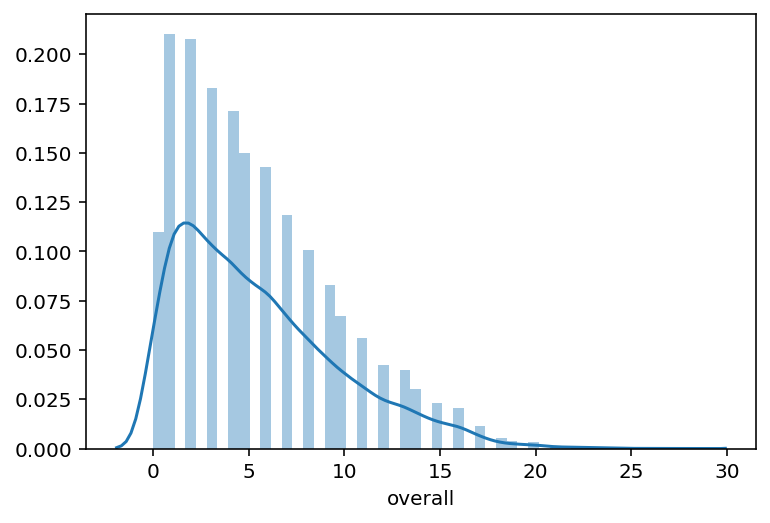

In [6]:


loss = abs(model_data.overall - model_data.overall.median())
sns.distplot(loss)

mu = loss.mean()
sigma = loss.std()

print(mu.round(2), sigma.round(2))

x = np.random.normal(10,2,size = 1000)



### Question 3: /3 Mark(s)
To prepare the data for modelling, the Senior Data Scientist recomends you use `sklearn.model_selection.train_test_split` to seperate the data into a training set and a test set.

The Senior Data Scientist would like to estimate the performance of the final selected model to within +/- 0.25 units using mean absolute error as the loss function of choice.  Decide on an appropriate size for the test set, then use `train_test_split` to split the features and target variables into appropriate sets.

In [7]:
# Need rationale or sample size
# Need an estimate for sigma 
# Use sigma from previous question
d = 0.25 #Provided from question
test_size = (2*sigma/d)**2

y = model_data.overall
X = model_data.drop('overall', axis = 'columns')

# Random state assures that folds are consistent across models
Xtrain, Xtest, ytrain, ytest = train_test_split(X,
                                                y, 
                                                test_size = int(np.ceil(test_size)), 
                                                random_state = 0)

print(Xtrain.shape,Xtest.shape)

(16831, 45) (1163, 45)


### Question 4: /1 Mark(s)


The Senior Data Scientist wants you to fit a linear regression to the data as a first model.  Use sklearn to build a model pipeline which fits a linear regression to the data. (This will be a very simple, one-step pipeline but we will expand it later.) You can read up on sklearn pipelines [here](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html). Note that the sklearn linear regression adds its own intercept so you don't need to create a column of 1s.

In [8]:
model_pipeline = Pipeline([
    ('linear_regression', LinearRegression())
])

### Question 5: /3 Mark(s)

The senior data scientist wants a report of this model's cross validation score.  Use 5 fold cross validation to estimate the out of sample performance for this model.  You may find sklearn's `cross_val_score` useful.

In [17]:
cv_score = cross_val_score(model_pipeline, Xtrain, ytrain, cv=5, scoring='neg_mean_absolute_error')

# cross_val_score uses "scorers" for which higher is better
cv_score_mean = -cv_score.mean()

print(cv_score_mean)

1.9055815330889483


### Question 6: /3 Mark(s)

That's impressive!  Your model seems to be very accurate, but now the Senior Data Scientist wants to try and make it more accurate.  Scouts have shared with the Senior Data Scientist that players hit their prime in their late 20s, and as they age they become worse overall.

The Senior Data Scientist wants to add a quadratic term for age to the model.  Repeat the steps above (creating a pipeline, validating the model, etc) for a model which includes a quadratic term for age.

In [18]:
# Here is one way to do this question
# Essentially, we manually add the age squared feature to our dataset
# and proceed as usual
y_quad = model_data.overall
X_quad = model_data.assign(age2 = lambda x: x.age**2).drop('overall', axis = 'columns')

X_quad_train, X_quad_test, y_quad_train, y_quad_test = train_test_split(X_quad, y_quad, 
                                                                        test_size = test_size, 
                                                                        random_state = 0)

quadratic_model_pipeline = Pipeline([
    ('linear_regression', LinearRegression())
])

quad_cv_score = cross_val_score(quadratic_model_pipeline, 
                                X_quad_train, 
                                y_quad_train, 
                                cv = 5, 
                                scoring = 'neg_mean_absolute_error')

# cross_val_score uses "scorers" for which higher is better
quad_cv_score_mean = -quad_cv_score.mean()

print(quad_cv_score_mean)

1.8872662605202275


In [13]:
# Here is another way using ColumnTransformer
# ColumnTransformer is a way to apply transforms to single columns or groups of columns
# without having to manually engineer the new feature.  It works a lot like Pipeline.
# This is nice because we can pass our raw data and not have to worry about computing the correct feature
# This sounds silly for something as easy as squaring a column, but when your features become more complex
# this becomes very usefil
from sklearn.compose import ColumnTransformer

# Using PolynomialFeatures to square the age column.
# The tuple looks like ('name_of_step', Transformer, ['column_you_want_to_transform'])
list_of_transforms = [('square_age', PolynomialFeatures(include_bias=False, interaction_only=False), ['age'])]

#remainder='passthrough' means that untransformed features are left alone and are not altered or thrown away.  Very important!!!
ct = ColumnTransformer(list_of_transforms, remainder='passthrough')

#Inclide as a part of our pipeline
model_with_age_squared = Pipeline([
    ('column_transformer', ct),
    ('linear_regression', LinearRegression())
])

#Proceed as usual.  Note I am passing the training data without the squared age column!
cv_score = cross_val_score(model_with_age_squared,
                          Xtrain,
                          ytrain,
                          cv=5,
                          scoring='neg_mean_absolute_error')

cv_score_mean = -cv_score.mean()

# Same Score as above.  A lille extra work for a lot of extra freedom and no worry!
print(cv_score_mean)

1.8872662605202266


### Question 7: /3 Mark(s)


The Senior Data Scientist isn't too happy that the quadratic term has not improved the fit of the model much and now wants to include quadratic and interaction term for every feature (That's a total of 1080 features!!!!)

Add sklearn's `PolynomialFeatures` to your pipeline from part C.  Report the cross validation score.

In [16]:
model_pipeline_intxn = Pipeline([
    ('poly', PolynomialFeatures(include_bias = False)),
    ('linear_regression', LinearRegression())
])

cv_score = cross_val_score(model_pipeline_intxn, 
                           Xtrain, 
                           ytrain, 
                           cv = 5, 
                           scoring = 'neg_mean_absolute_error')

print(-cv_score.mean())


0.8861587663418822


### Question 8: /2 Mark(s)

The Senior Data Scientist is really happy with the results of adding every interaction into the model and wants to explore third order interactions (that is adding cubic terms to the model).

This is not a good idea!  Talk them down from the ledge.  Write them an email in the cell below explaining what could happen if you add too may interactions.

---

Hey Boss,

I got your email about adding cubic terms to the model.  I think...adding cubic terms to the model will likely overfit the data.  If we add cubic terms, then the number of predictors will be very close to the number of observations.  This will make it easy for us to get a low training error, but will likely not generalize very well. It is my recomendation that we NOT add cubic terms.

Sincerly,

Junior Data Scientist



### Question 9:  /2 Mark(s)

You've successfully talked the Senior Data Scientist out of adding cubic terms to the model. Good job!

Based on the cross validation scores, which model would you choose?  Estimate the performance of your chosen model on the test data you held out, and do the following:

- Compute a point estimate for the generalization error.
- Compute a confidence interval for the generalization error.  
- Plot the distribution of the absolute errors.

Is the test error close to the cross validation error of the model you chose? Why do you think this is the case?


Generalization Error:  0.87
Confidence interval:  [0.82 0.91]


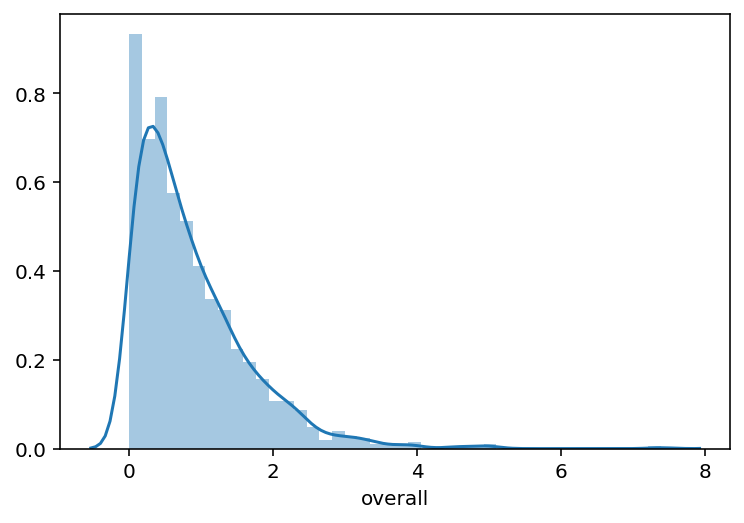

In [20]:
# Fit our best performing model on all the training data
model_pipeline_intxn.fit(Xtrain, ytrain)

#Predict on the test set
ypred = model_pipeline_intxn.predict(Xtest)

#Compute the errors and a point estimate of the generalization error
test_errors = np.abs(ytest - ypred)
generalization_error = test_errors.mean()

#Construct a confidence interval
# We have enough data in our test set that the appropirate t-quantile is close to 1.96
test_ci = generalization_error + 1.96 * np.std(test_errors) / np.sqrt(len(test_errors)) * np.array([-1, 1])

sns.distplot(abs(test_errors))

print('Generalization Error: ',generalization_error.round(2))
print('Confidence interval: ', test_ci.round(2))

### Follow These Steps before submitting
Once you are finished, ensure to complete the following steps.

1.  Restart your kernel by clicking 'Kernel' > 'Restart & Run All'.

2.  Fix any errors which result from this.

3.  Repeat steps 1. and 2. until your notebook runs without errors.

4.  Submit your completed notebook to OWL by the deadline.